In [0]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from PIL import Image, ImageDraw
from pathlib import Path
import re

from tqdm import tqdm, tqdm_notebook

import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from matplotlib import image, patches, pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Датасет [DeepFashion2](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html) подгружаю и распаковываю из google drive

In [3]:
!unzip -q /content/gdrive/My\ Drive/DeepFashion2/img_copy.zip -d data_folder
!mkdir Anno
!cp -avr /content/gdrive/My\ Drive/DeepFashion2/Anno /content/

'/content/gdrive/My Drive/DeepFashion2/Anno/list_attr_img.txt' -> '/content/Anno/list_attr_img.txt'
'/content/gdrive/My Drive/DeepFashion2/Anno/list_attr_cloth.txt' -> '/content/Anno/list_attr_cloth.txt'
'/content/gdrive/My Drive/DeepFashion2/Anno/list_category_img.txt' -> '/content/Anno/list_category_img.txt'
'/content/gdrive/My Drive/DeepFashion2/Anno/list_landmarks.txt' -> '/content/Anno/list_landmarks.txt'
'/content/gdrive/My Drive/DeepFashion2/Anno/list_bbox.txt' -> '/content/Anno/list_bbox.txt'
'/content/gdrive/My Drive/DeepFashion2/Anno/list_category_cloth.txt' -> '/content/Anno/list_category_cloth.txt'


In [4]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 112
DEVICE = torch.device("cuda:0")
BATCH_SIZE = 64
DEVICE

device(type='cuda', index=0)

Примечание, баундинг боксы можно представлять двух видах:
1. Координата центра bounding box'а, его ширина и длинна
2. Координаты двух противоположных точек прямоугольника

В датасете представлен 2 вид, так и оставим, на нашем простеньком примере предобработка к 1 виду не принесет особой выгоды

In [0]:
class DeepFashionDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = files
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = files['num_type']
            self.label_encoder.fit(self.labels)
            self.bboxes = files[['x_1', 'y_1', 'x_2', 'y_2']]
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file['path'])
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        x = self.load_sample(self.files.loc[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        inputs = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            labels = label_id.item()
            bboxes = torch.cuda.FloatTensor(self.bboxes.iloc[index])            
            return inputs, bboxes, labels
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Создаем произвольную функцию ошибки, которая будет включать в себя сумму с коэффициентом среднеквадратичного отклонения координат bbox'ов и стандартную функцию потерь для классификациюю - Cross Entropy 

In [0]:
def customloss(pred_bboxes, pred_labels, true_bboxes, true_labels):
    cross_entropy = nn.CrossEntropyLoss()(pred_labels, true_labels).to(DEVICE)
    MSE = nn.MSELoss()(pred_bboxes, true_bboxes).to(DEVICE)
    return cross_entropy + 5 * MSE

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_rounds = 0
  
    for inputs, bboxes, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        bboxes = bboxes.to(DEVICE)
        optimizer.zero_grad()
        bbox_output, label_output = model(inputs)
        loss = criterion(bbox_output, label_output, bboxes, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_rounds += 1
              
    train_loss = running_loss / running_rounds
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_rounds = 0

    for inputs, bboxes, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        bboxes = bboxes.to(DEVICE)

        with torch.set_grad_enabled(False):
            bbox_output, label_output = model(inputs)
            loss = criterion(bbox_output, label_output, bboxes, labels)

        running_loss += loss
        running_rounds += 1
    val_loss = running_loss / running_rounds
    return val_loss
    
def train(train_files, val_files, model, epochs, batch_size, lr):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = customloss

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, val_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))
    return history

In [0]:
PATH = Path('./data_folder/')
train_val_files = sorted(list(PATH.rglob('*.jpg'))) 

In [0]:
with open('/content/Anno/list_category_img.txt', 'r') as category_img_file, \
    open('/content/Anno/list_bbox.txt', 'r') as bbox_file:
        list_category_img = [line.rstrip('\n') for line in category_img_file][2:]
        list_bbox = [line.rstrip('\n') for line in bbox_file][2:]
        
list_category_img = [line.split('_')[-2].replace('/img', '') for line in list_category_img]
list_bbox = [re.compile("\s+").split(line) for line in list_bbox]
list_all = pd.DataFrame(list_bbox, columns=['path', 'x_1', 'y_1', 'x_2', 'y_2'])
list_all['type'] = list_category_img
list_all.loc[:, 'path'] = './data_folder/' + list_all['path']
list_all.loc[:, ['x_1', 'y_1', 'x_2', 'y_2']] = list_all.loc[:, ['x_1', 'y_1', 'x_2', 'y_2']].astype(float)
image_size = list_all.loc[:, 'path'].map(lambda x: image.imread(x).shape[0:2])
list_all['image_size'] = image_size
list_all['image_size_x'] = list_all['image_size'].map(lambda x: x[1])
list_all['image_size_y'] = list_all['image_size'].map(lambda x: x[0])
list_all = list_all.drop('image_size', axis=1)
# Так как картинки разных размеров - переводим bbox из чисел в проценты
list_all.loc[:, 'x_1'] = list_all.loc[:, 'x_1'] / list_all.loc[:, 'image_size_x']
list_all.loc[:, 'x_2'] = list_all.loc[:, 'x_2'] / list_all.loc[:, 'image_size_x']
list_all.loc[:, 'y_1'] = list_all.loc[:, 'y_1'] / list_all.loc[:, 'image_size_x']
list_all.loc[:, 'y_2'] = list_all.loc[:, 'y_2'] / list_all.loc[:, 'image_size_y']

In [0]:
def draw_rect(df):
    image = df['path']
    xx = df[['x_1', 'x_2']] * df['image_size_x']
    yy = df[['y_1', 'y_2']] * df['image_size_y']
    im = Image.open(image)
    draw = ImageDraw.Draw(im)   
    draw.rectangle(xy=[xx[0], yy[0], xx[1], yy[1]], outline='red', width=2)
    image = np.asarray(im)
    plt.imshow(image)
    plt.title(df['type'])
    plt.show()

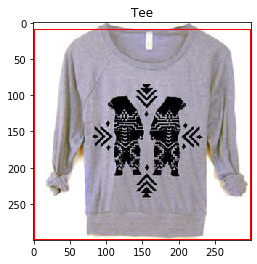

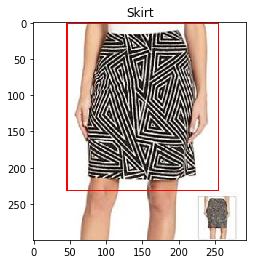

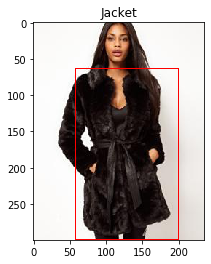

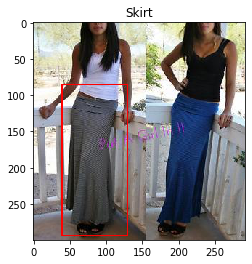

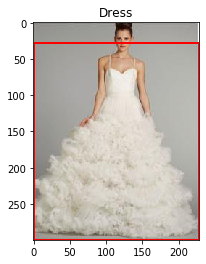

In [109]:
for i in range(5):
    random_number = np.random.randint(0, list_all.shape[0])
    draw_rect(list_all.loc[random_number])

Можно заметить, что данные шумные, присутсвуют по несколько типов одежды на одном человеке, иногда присутсвуют несколько людей, это будет затруднять обучение модели и ее оценку

In [0]:
label_dict = {sorted(list_all['type'].unique())[i]: i for i in range(list_all['type'].nunique())}
inv_dict = {v: k for k, v in label_dict.items()}
list_all.loc[:, 'num_type'] = list_all.loc[:, 'type'].replace(label_dict)
dataset = list_all.drop(['type', 'image_size_x', 'image_size_y'], axis=1)

Данных в данном датасете много, при обучении colab падает, чтобы сократить время обучения просто делим наш датасет пополам на train/val

In [0]:
train_files, val_files = train_test_split(dataset, test_size=0.5, stratify=dataset['num_type'])
train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)

Задача простая, картинки отмасштабированы к 122*122, поэтому большая сеть нам будет ни к чему. Используем самописный упрощенный и уменьшенный вариант resnet'а 

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                    stride=stride, padding=1, bias=False)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
          
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, 
                                  track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, 
                                  track_running_stats=True)
        self.downsample = downsample

    def forward(self, x):
        redusal = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            redusal = self.downsample(redusal)
        out += redusal
        out = self.relu(out)
        return out

class ResBlockNet(nn.Module):
    def __init__(self):
        super(ResBlockNet, self).__init__()
        
        self.in_channels = 32
        self.conv0 = nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn0 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = self._make_layers(64, 2)
        self.layer2 = self._make_layers(128, 2)
        self.ad_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.fc1 = nn.Linear(128, 64, bias=True)
        self.bn_fc = nn.BatchNorm1d(64)
        self.f3_l = nn.Linear(128, 46, bias=True)
        self.f3_b = nn.Linear(128, 4, bias=True)

    def _make_layers(self, out_channels, n_layers, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True,
                               track_running_stats=True))
        layers = []
        layers.append(ResBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, n_layers):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.layer1(out)
        out = self.layer2(out)

        out = self.ad_pool(out)
        out = torch.flatten(out, 1)
        label_out = self.f3_l(out)
        bbox_out = self.f3_b(out)
        bbox_out = torch.clamp(bbox_out, 0, 1) # Не забываем клипнуть выход с bbox'ов 
        return bbox_out, label_out

In [0]:
val_dataset = DeepFashionDataset(val_files, mode='val')
train_dataset = DeepFashionDataset(train_files, mode='train')

In [0]:
resblocknet = ResBlockNet().to(DEVICE)

In [118]:
history = train(train_dataset, val_dataset, model=resblocknet, epochs=4, 
                batch_size=BATCH_SIZE, lr=8e-4)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss tensor(2.2125, device='cuda:0', grad_fn=<DivBackward0>)


epoch:  25%|██▌       | 1/4 [13:24<40:14, 804.91s/it]


Epoch 001 train_loss: 2.2125     val_loss 1.9910
loss tensor(1.8735, device='cuda:0', grad_fn=<DivBackward0>)


epoch:  50%|█████     | 2/4 [26:40<26:44, 802.08s/it]


Epoch 002 train_loss: 1.8735     val_loss 1.7681
loss tensor(1.7050, device='cuda:0', grad_fn=<DivBackward0>)


epoch:  75%|███████▌  | 3/4 [40:02<13:22, 802.20s/it]


Epoch 003 train_loss: 1.7050     val_loss 1.6641
loss tensor(1.6193, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 100%|██████████| 4/4 [53:28<00:00, 803.25s/it]


Epoch 004 train_loss: 1.6193     val_loss 1.6148


In [0]:
def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [0]:
def draw_output(data):
    x0 = data[1][0] * 112
    y0 = data[1][1] * 112
    width = (data[1][2] - data[1][0]) * 112
    height = (data[1][3] - data[1][1]) * 112
    preds = resblocknet.forward(data[0].unsqueeze(0).to(DEVICE))
    x0pred = preds[0][0][0] * 112
    y0pred = preds[0][0][1]  * 112
    widthpred = (preds[0][0][2] - preds[0][0][0]) * 112
    heightpred = (preds[0][0][3] - preds[0][0][1]) * 112

    fig, ax = plt.subplots(1)
    ax.imshow(np.moveaxis(data[0].cpu().numpy(), 0, 2))
    true_rect = patches.Rectangle((x0, y0), width, height, linewidth=2, 
                                  edgecolor='r', facecolor='None', label='true')
    pred_rect = patches.Rectangle((x0pred, y0pred), widthpred, heightpred, linewidth=2, 
                                  edgecolor='b', facecolor='None', label='pred')
    _, indx = resblocknet.forward(data[0].unsqueeze(0).to(DEVICE))[1].max(1)
    ax.set_title('True: {} Predicted: {}'.format(inv_dict[data[2]], inv_dict[indx.item()]))
    ax.add_patch(true_rect)
    ax.add_patch(pred_rect)
    
    plt.show()
    print('IoU score: {:2}'.format(get_iou(data[1].cpu().numpy(), 
                                           preds[0][0])))
    print('___________________________________________')

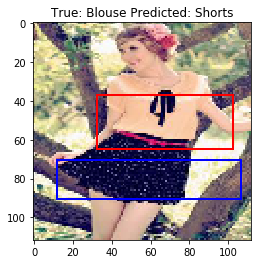

IoU score: 0.0
___________________________________________


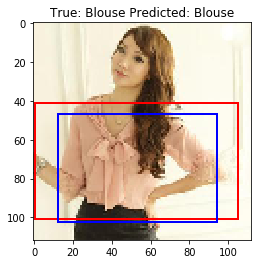

IoU score: 0.6932092308998108
___________________________________________


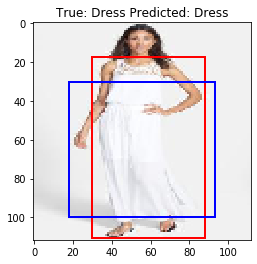

IoU score: 0.6137402057647705
___________________________________________


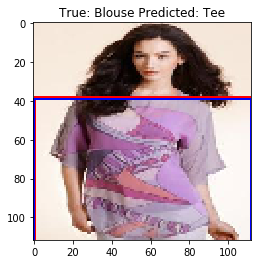

IoU score: 0.9796111583709717
___________________________________________


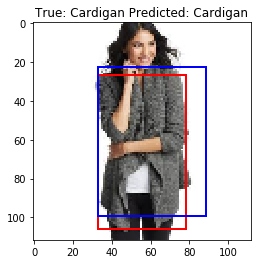

IoU score: 0.714711606502533
___________________________________________


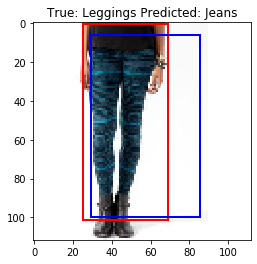

IoU score: 0.6188703775405884
___________________________________________


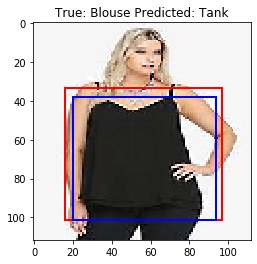

IoU score: 0.8471543788909912
___________________________________________


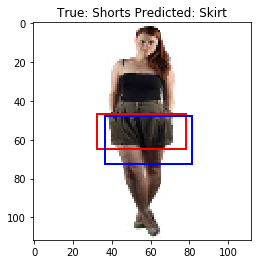

IoU score: 0.5832773447036743
___________________________________________


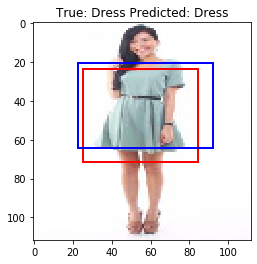

IoU score: 0.6954102516174316
___________________________________________


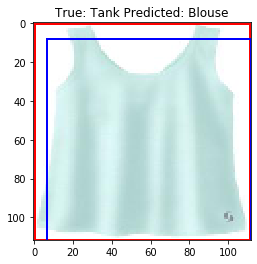

IoU score: 0.8701979517936707
___________________________________________


In [220]:
rn = np.random.randint(0, 50000)
for i in range(rn, rn+10):
    draw_output(val_dataset[i])

На данном примере прекрасно видно, что некоторая часть данных грязная, присутствуют несколько типов одежды на одном изображении - на первом изображении сеть предсказала и выделила юбку, но таргетом служит блузка

Данную можель еще можно дообучить, чтобы получить более точные предсказания (но, к сожалению, датасет сликом большой и технические ограничения заставляют окончить на данном варианте)